In [250]:
import pandas as pd
import numpy as np
import requests
import time
import os
from pathlib import Path
from dotenv import load_dotenv

### **Import S&P 500**

In [251]:
# Import historical S&P 500 data (csv)
sp500_path = Path("resources/^GSPC.csv")  # Source: Yahoo Finance (https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1597708800&interval=1d&filter=history&frequency=1d)
sp500_df = pd.read_csv(sp500_path)
sp500_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
23262,2020-08-11,3370.340088,3381.010010,3326.439941,3333.689941,3333.689941,5087650000
23263,2020-08-12,3355.459961,3387.889893,3355.459961,3380.350098,3380.350098,3768560000
23264,2020-08-13,3372.949951,3387.239990,3363.350098,3373.429932,3373.429932,3648810000
23265,2020-08-14,3368.659912,3378.510010,3361.639893,3372.850098,3372.850098,3193400000
23266,2020-08-17,3380.860107,3387.590088,3379.219971,3381.989990,3381.989990,3671290000


In [252]:
# Clean historical S&P 500
# sp500_df = sp500_df.set_index('Date')
sp500_daily_historical = sp500_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
sp500_daily_historical = sp500_daily_historical.rename(columns={'Adj Close':'S&P 500'})
sp500_daily_historical = sp500_daily_historical.round(2)
sp500_daily_historical = sp500_daily_historical[:-3]
sp500_daily_historical['Date'] = pd.to_datetime(sp500_daily_historical['Date'])
sp500_daily_historical = sp500_daily_historical.set_index('Date')
# sp500_daily_historical.tail(3)

In [253]:
# Get most recent S&P 500 data 
import pandas_datareader.data as web
import datetime

# last_historical_day = sp500_daily_historical.iloc[-1]['Date']
# start = datetime.datetime.strptime(last_historical_day, '%Y-%m-%d').date()
# end = datetime.date.today()
sp500_current = web.DataReader(['sp500'], 'fred')
sp500_current = sp500_current.reset_index()
sp500_current = sp500_current.rename(columns={'DATE':'Date', 'sp500':'S&P 500'})
sp500_current = sp500_current.set_index('Date')
sp500_current.info()
# print(start, end)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2015-08-27 to 2020-08-24
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  1257 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


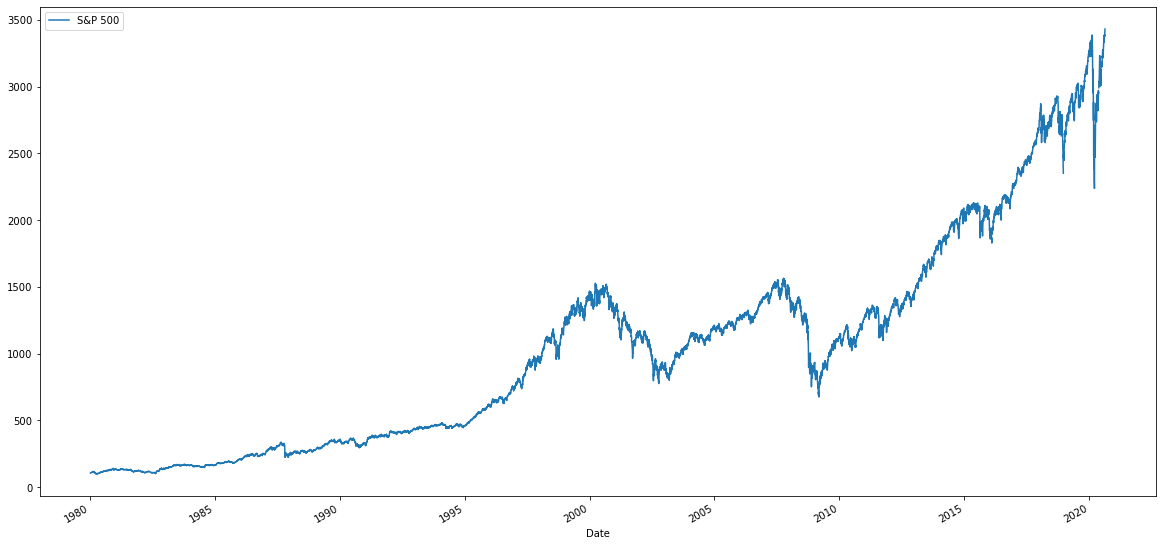

In [276]:
# Combine Historical S&P and Most recent S&P
sp500_daily = pd.concat([sp500_daily_historical, sp500_current], axis=0, join='outer')
# sp500_daily = pd.merge(sp500_daily_historical, sp500_current, left_on= ['Date', 'S&P 500'],
#                    right_on= ['DATE', 'sp500'], how='outer')
sp500_daily = sp500_daily.loc['1980':]
sp500_daily.plot(figsize=(20,10))

In [277]:
sp500_daily.head()

,S&P 500
Date,
1980-01-02,105.76
1980-01-03,105.22
1980-01-04,106.52
1980-01-07,106.81
1980-01-08,108.95


In [278]:
# Check if combined properly (Check if duplicate date)

# sp500_daily = sp500_daily.reset_index()
# sp500_daily[sp500_daily.duplicated(['Date'])]
# sp500_daily['Date'] = sp500_daily['Date'].drop_duplicates()
# sp500_daily = sp500_daily.set_index('Date')

In [279]:
# Drop rows with duplicated datetime index
sp500_daily['index'] = sp500_daily.index
sp500_daily= sp500_daily.drop_duplicates('index')
sp500_daily.set_index = sp500_daily['index']
sp500_daily= sp500_daily.drop('index', axis =1)

sp500_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10296 entries, 1980-01-02 to 2020-08-24
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  10250 non-null  float64
dtypes: float64(1)
memory usage: 160.9 KB


In [280]:
# Check if csv exist. If not, create new saved_stock csv (with sp500 in it)
stock_data_path = Path("resources/saved_stock.csv")
try:
    df = pd.read_csv(stock_data_path)
    print('csv exist')

except FileNotFoundError:
    sp500_daily.to_csv("resources/saved_stock.csv")
    print('No csv. Created new one')



csv exist


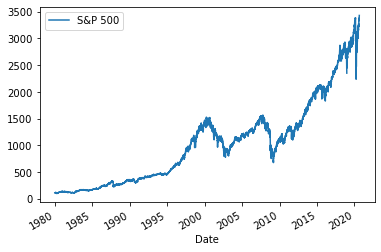

In [281]:
# sp500_daily.head()
sp500_daily.plot()

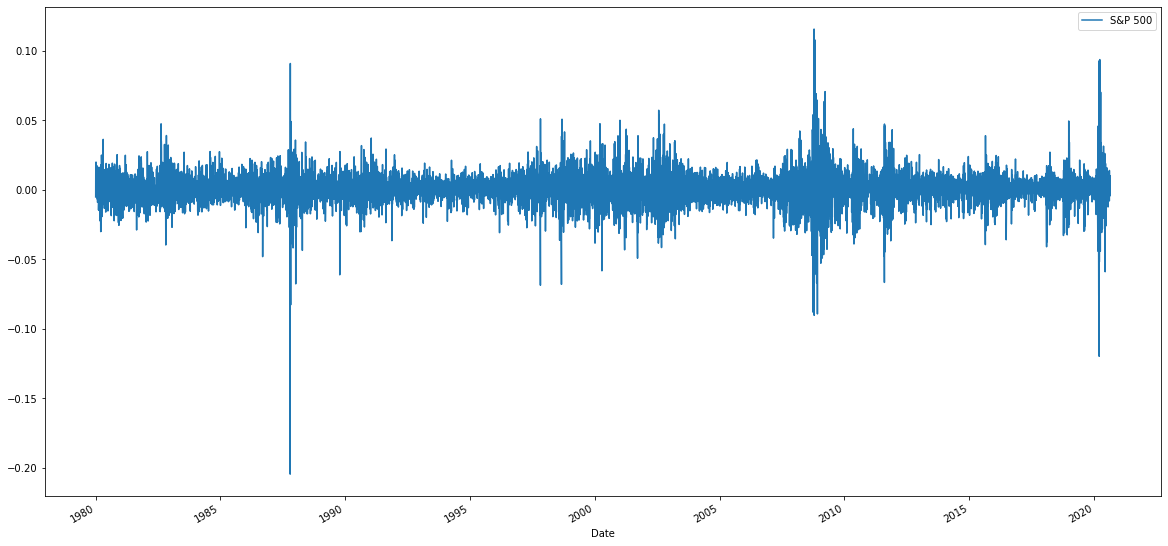

In [282]:
# Calculate Daily Returns - S&P 500
sp500_returns = sp500_daily.pct_change()
sp500_returns = sp500_returns.dropna()
sp500_returns.plot(figsize=(20,10))

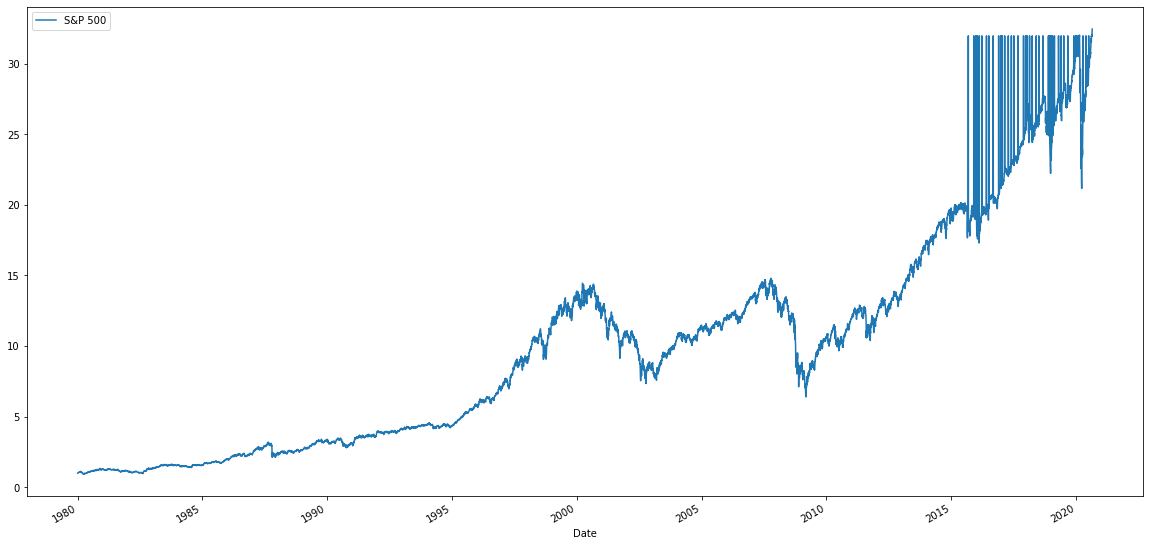

In [283]:
# Calculate Cumulative Returns - S&P 500
sp500_cum_returns = (1+sp500_returns).cumprod()
sp500_cum_returns.plot(figsize=(20,10))

In [284]:
# Calculate Standard Deviation - S&P 500
sp500_std = sp500_returns.std()
sp500_std

S&P 500    0.011286
dtype: float64

### **Import Alpha Vantage Stocks**

In [285]:
load_dotenv()

True

In [286]:
# Get alpha-vantage api key
alphavantage_api_key = os.getenv("ALPHAVANTAGE_API_KEY")
type(alphavantage_api_key)

str

In [287]:
# import alpha-vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.timeseries import TimeSeries

ts = TimeSeries(key=alphavantage_api_key, output_format='pandas')

In [266]:
# def get_daily(quote):
#     """GET stock's daily adjusted data using alpha vantage api """
#     data, meta_data = ts.get_daily_adjusted(quote, outputsize='full')
#     data = data.sort_index(ascending=True)
#     return data

In [267]:
# def setup_adjusted_close(quote, stock_data):
#     """Clean stock data: drop col, rename col"""
#     stock_data = stock_data.drop(columns=['1. open', '2. high', '3. low', '4. close',
#            '6. volume', '7. dividend amount', '8. split coefficient'])
#     stock_data = stock_data.rename(columns = {'5. adjusted close':quote})
#     stock_data.index.names = ['Date']
#     #     stock_data.dropna(inplace=True)
#     return stock_data

In [293]:
# Load saved stock data (from previous runs)
stock_data_path = Path('resources/saved_stock.csv')
saved_stock_df = pd.read_csv(stock_data_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
saved_stock_df.head(3)

,S&P 500,EA,TTWO,ATVI
Date,,,,
1980-01-02,105.76,NaN,NaN,NaN
1980-01-03,105.22,NaN,NaN,NaN
1980-01-04,106.52,NaN,NaN,NaN


In [294]:
# Get stock data from Alpha Vantage (if not already in csv)
def get_daily(df, get_stock_list, saved_stock_list):
    """If stock not in saved df, call api (timeout for api request limit. AlphaVantage - 5 requests/min)"""

    for stock in get_stock_list:
        if stock not in saved_stock_list:
            print('call api for ' + stock)
            data, meta_data = ts.get_daily_adjusted(stock, outputsize='full')
            df[stock] = data['5. adjusted close'].sort_index(ascending=True)
            time.sleep(12)
    return df

    
stock_list = ['EA', 'TTWO', 'ATVI']  # stocks to get from Alpha Vantage
saved_stock_quotes = list(saved_stock_df.columns)  # stocks already saved in csv
all_portfolio = get_daily(saved_stock_df, stock_list, saved_stock_quotes) # Get stock from AlphaVantage api
all_portfolio = all_portfolio.sort_index(ascending=True)
all_portfolio.tail()

,S&P 500,EA,TTWO,ATVI
Date,,,,
2020-08-18,3389.78,142.58,176.98,83.130
2020-08-19,3374.85,141.86,172.63,81.980
2020-08-20,3385.51,143.48,174.43,83.995
2020-08-21,3397.16,141.21,173.14,83.210
2020-08-24,3431.28,142.33,172.55,83.100


In [295]:
# def test_get_daily():
#     """ TEST get_daily. Should print 'call api for EA, stock exist', call api for ATVI"""
#     df = pd.DataFrame({'DATE':pd.date_range('2017-01-01', periods=5, freq='D'), 'FB':[1,2,3,4,5], 'AMZN':[7,6,9,8,0]})
#     df = df.set_index('DATE')
# #     test_stock_list = ['EA', 'FB', 'ATVI']
#     test_stock_list = ['EA', 'FB']
#     test_saved_stock_quotes = list(df.columns)
    
#     #Below - Code for get_daily()
#     for stock in test_stock_list:
#         if stock in test_saved_stock_quotes:
#             print('stock exist')
#         else:
#             data, meta_data = ts.get_daily_adjusted(stock, outputsize='full')
#             df[stock] = data['5. adjusted close'].sort_index(ascending=True)
#             print('call api for ' + stock)
#             time.sleep(12)
#     return df

# print(test_get_daily())

In [296]:
# Check data, ensure no duplicated datetime index 
all_portfolio.info()
idx = all_portfolio.index
print("\n" "number of duplicated datetime index: " + str(idx.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10296 entries, 1980-01-02 to 2020-08-24
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  10250 non-null  float64
 1   EA       5237 non-null   float64
 2   TTWO     5237 non-null   float64
 3   ATVI     5237 non-null   float64
dtypes: float64(4)
memory usage: 402.2 KB

number of duplicated datetime index: 0


In [310]:
# Save stock into csv 
all_portfolio.to_csv("resources/saved_stock.csv")
all_portfolio.head(3)

,S&P 500,EA,TTWO,ATVI
Date,,,,
1980-01-02,105.76,NaN,NaN,NaN
1980-01-03,105.22,NaN,NaN,NaN
1980-01-04,106.52,NaN,NaN,NaN


In [308]:
# Get Gaming Industry Portfolio
gaming_industry = all_portfolio[['EA', 'TTWO', 'ATVI']]
gaming_industry.head(3)

,EA,TTWO,ATVI,S&P 500
Date,,,,
1999-01-04,NaN,NaN,NaN,1228.10
1999-01-05,NaN,NaN,NaN,1244.78
1999-01-06,NaN,NaN,NaN,1272.34


In [ ]:
oil_industry = all_portfolio[['XON', 'CVX', 'COP', 'HAL', 'KMI', 'PSX', 'EPD', 'ET', 'PAA']]
defense_industry = all_portfolio[['LMT', 'RTN', 'LDOS', 'BA', 'NOC', 'GD', 'OSK', 'KBR']]
tech_industry = all_portfolio[['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'MCST', 'IBM', 'INTC', 'PYPL']]
finance_industry = all_portfolio[['']]
airlines_industry = all_portfolio[[]]
wasteservice_industry = all_portfolio[[]]

In [311]:
# Check data
gaming_industry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5492 entries, 1999-01-04 to 2020-08-24
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EA       5237 non-null   float64
 1   TTWO     5237 non-null   float64
 2   ATVI     5237 non-null   float64
 3   S&P 500  5446 non-null   float64
dtypes: float64(4)
memory usage: 214.5 KB


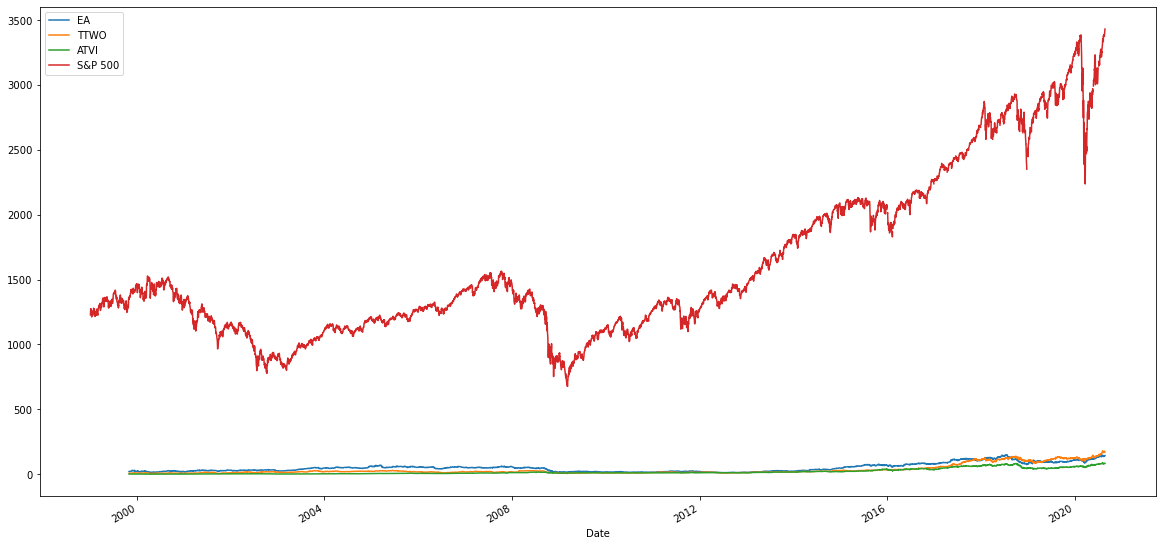

In [312]:
# Plot - Gaming Industry
gaming_industry.plot(figsize=(20,10))

In [313]:
# Calculate Daily Returns - 
gaming_returns = gaming_industry.pct_change()
gaming_returns = gaming_returns.dropna()
gaming_returns.head()

,EA,TTWO,ATVI,S&P 500
Date,,,,
1999-11-02,-0.037177,0.024253,0.013523,-0.004712
1999-11-03,-0.022839,0.047344,0.017570,0.005335
1999-11-04,0.023373,0.000000,0.008310,0.005690
1999-11-05,0.033186,0.028929,0.051923,0.005570
1999-11-08,0.013679,0.000000,0.040306,0.004948


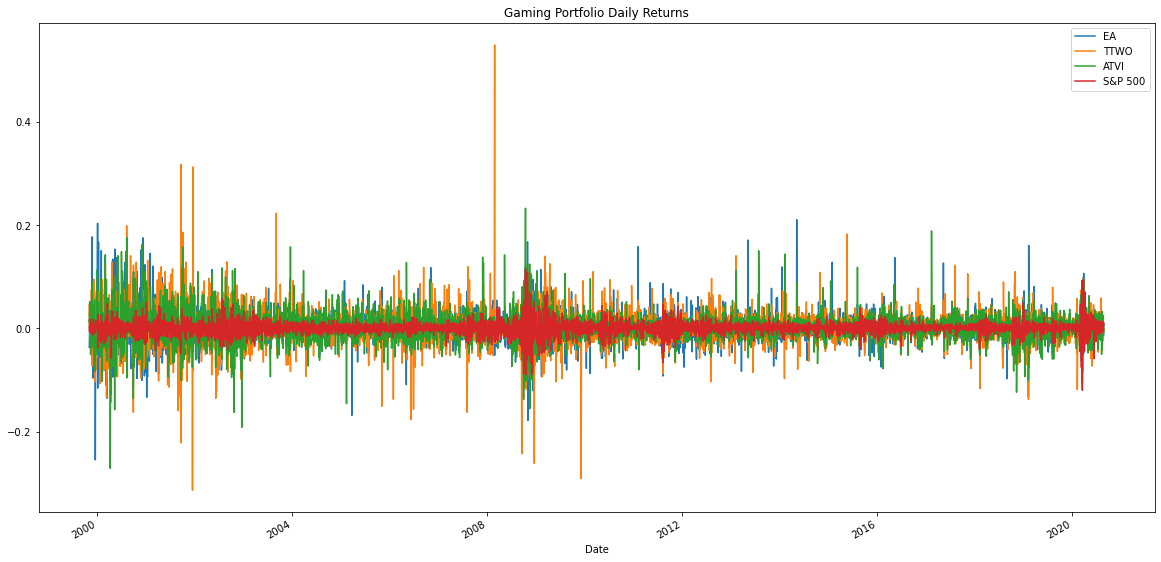

In [314]:
# Plot Daily Returns
gaming_returns.plot(figsize=(20, 10), title="Gaming Portfolio Daily Returns")

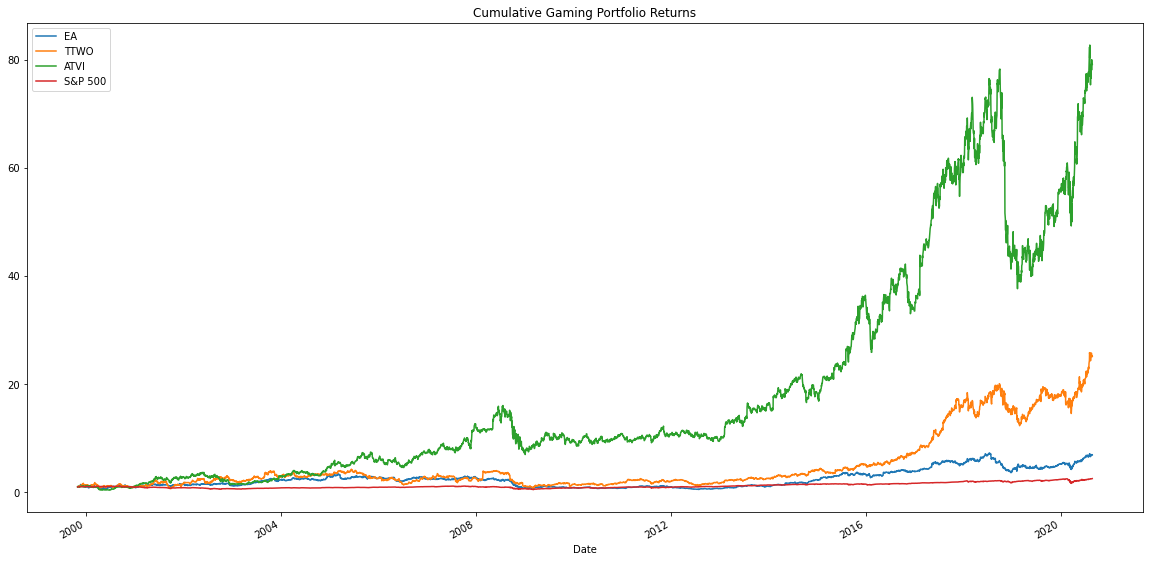

In [316]:
# Plot Cumulative Returns - Gaming Portfolio
gaming_cumulative_returns = (1 + gaming_returns).cumprod()
gaming_cumulative_returns.plot(figsize=(20,10), title="Cumulative Gaming Portfolio Returns")

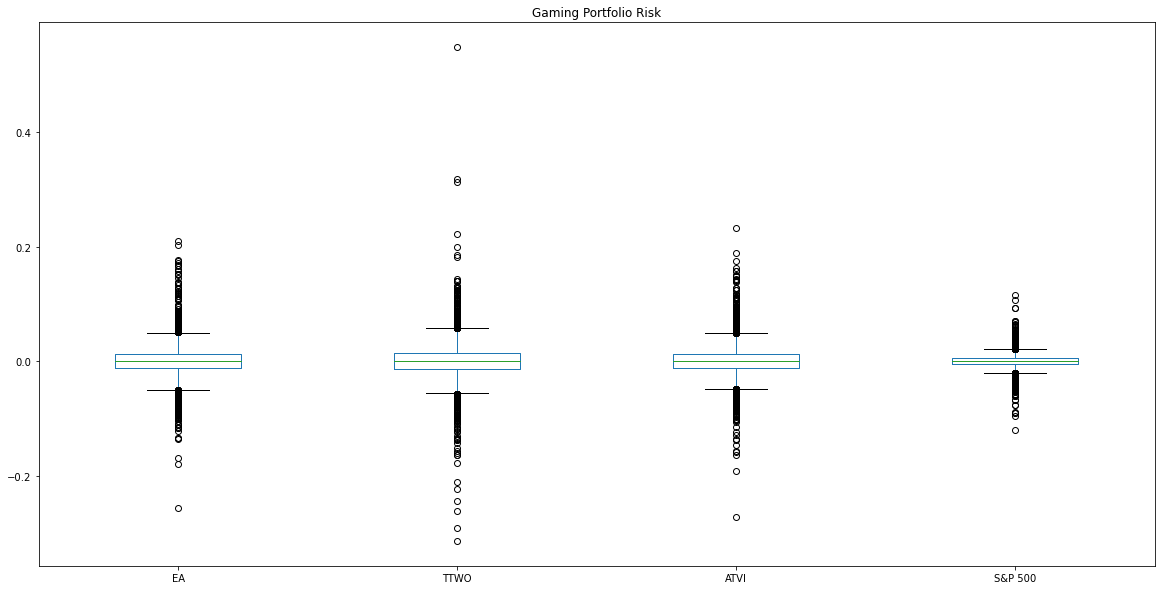

In [317]:
# Box Plot - Daily Returns - Gaming Portfolio
gaming_returns.plot.box(figsize=(20, 10), title="Gaming Portfolio Risk")

In [318]:
# Daily Standard Deviations - Gaming Portfolio
gaming_returns.std()

EA         0.027146
TTWO       0.032645
ATVI       0.026963
S&P 500    0.012462
dtype: float64

In [319]:
# Calculate the annualized standard deviation (252 trading days)
gaming_returns.std() * np.sqrt(252)

EA         0.430925
TTWO       0.518225
ATVI       0.428019
S&P 500    0.197826
dtype: float64

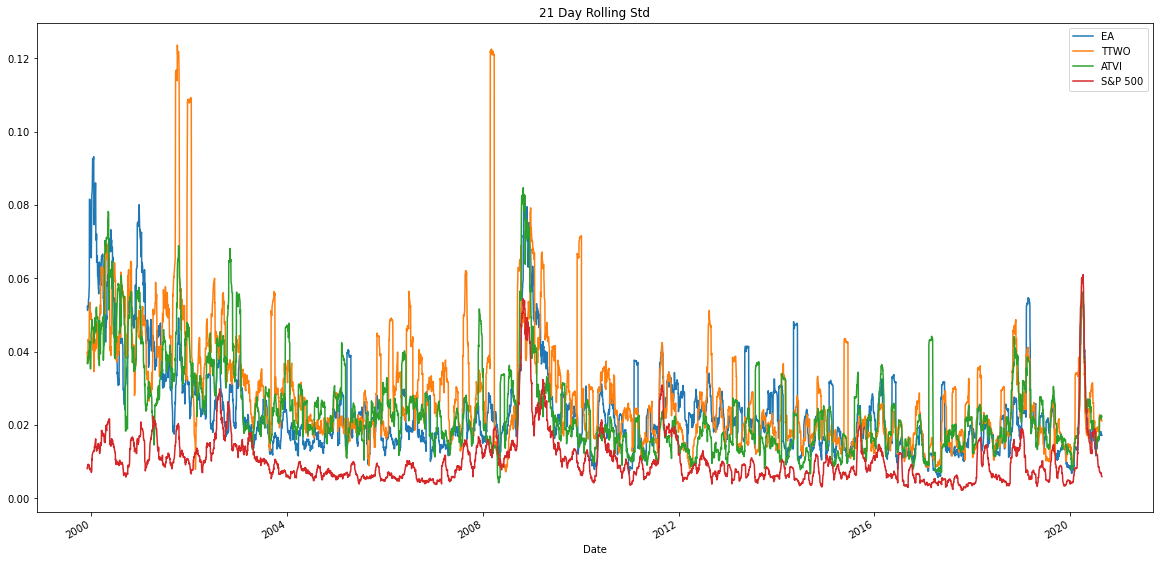

In [320]:
# Rolling Std - Gaming Industry
gaming_returns.rolling(window=21).std().plot(figsize=(20, 10), title="21 Day Rolling Std")

In [321]:
# Correlation table - Gaming Industry
corr_df = gaming_returns.corr()
corr_df.style.background_gradient()

,EA,TTWO,ATVI,S&P 500
EA,1.000000,0.352202,0.456171,0.481701
TTWO,0.352202,1.000000,0.368609,0.389087
ATVI,0.456171,0.368609,1.000000,0.447125
S&P 500,0.481701,0.389087,0.447125,1.000000
